===================================================
Faces recognition example using eigenfaces and SVMs
===================================================

The dataset used in this example is a preprocessed excerpt of the
"Labeled Faces in the Wild", aka LFW_:

  http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz (233MB)

 LFW_ http://vis-www.cs.umass.edu/lfw/

  original source: http://scikit-learn.org/stable/auto_examples/applications/face_recognition.html



In [1]:
from time import time
import logging
import pylab as pl
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_lfw_people
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC

/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [3]:
# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')

In [4]:
###############################################################################
# Download the data, if not already on disk and load it as numpy arrays
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)


2017-09-19 21:55:06,951 Loading LFW people faces from /home/jovyan/scikit_learn_data/lfw_home


In [5]:
# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape
np.random.seed(42)

# for machine learning we use the data directly (as relative pixel
# position info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


In [6]:
###############################################################################
# Split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

###############################################################################
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 150

print("Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0]))
t0 = time()
pca = PCA(svd_solver='randomized',n_components=n_components, whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))

print(pca.explained_variance_ratio_)  

Extracting the top 150 eigenfaces from 966 faces
done in 4.774s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.116s
[ 0.18185242  0.15184097  0.07408637  0.06062211  0.05297484  0.03076076
  0.02535245  0.02125173  0.02037618  0.01917451  0.01637194  0.01496886
  0.01276692  0.01099863  0.01063904  0.00987084  0.00917055  0.00887507
  0.00786596  0.00689641  0.00683706  0.00660658  0.00627254  0.00598772
  0.00558805  0.00552445  0.0051956   0.00484247  0.00456562  0.0043921
  0.00408504  0.00385494  0.00368885  0.00362346  0.00350294  0.00327206
  0.00320325  0.00303117  0.00293385  0.00287654  0.00275882  0.00271965
  0.00263256  0.00256486  0.00240954  0.00235722  0.00232249  0.00228703
  0.00225993  0.0022243   0.00212605  0.00204763  0.00200274  0.00196252
  0.001921    0.00190196  0.00185983  0.001821    0.00179572  0.00168347
  0.00166913  0.00162619  0.0015835   0.00155219  0.00153598  0.00149491
  0.00145789  0.00143221  0.00141004  0.00140464  0.00134

In [7]:
###############################################################################
# Train a SVM classification model

param_grid = {
         'C': [1e3, 5e3, 1e4, 5e4, 1e5],
          'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
          }


In [8]:

print("Fitting the classifier to the training set")
t0 = time()

clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)


Fitting the classifier to the training set
done in 47.480s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.005, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [9]:
###############################################################################
# Quantitative evaluation of the model quality on the test set

print("Predicting the people names on the testing set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

Predicting the people names on the testing set
done in 0.130s
                   precision    recall  f1-score   support

     Ariel Sharon       1.00      0.77      0.87        13
     Colin Powell       0.82      0.90      0.86        60
  Donald Rumsfeld       0.90      0.70      0.79        27
    George W Bush       0.88      0.96      0.92       146
Gerhard Schroeder       0.96      0.88      0.92        25
      Hugo Chavez       1.00      0.73      0.85        15
       Tony Blair       1.00      0.86      0.93        36

      avg / total       0.90      0.89      0.89       322

[[ 10   3   0   0   0   0   0]
 [  0  54   1   5   0   0   0]
 [  0   2  19   6   0   0   0]
 [  0   5   1 140   0   0   0]
 [  0   0   0   3  22   0   0]
 [  0   2   0   2   0  11   0]
 [  0   0   0   4   1   0  31]]


In [10]:
###############################################################################
# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    pl.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    pl.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        pl.subplot(n_row, n_col, i + 1)
        pl.imshow(images[i].reshape((h, w)), cmap=pl.cm.gray)
        pl.title(titles[i], size=12)
        pl.xticks(())
        pl.yticks(())

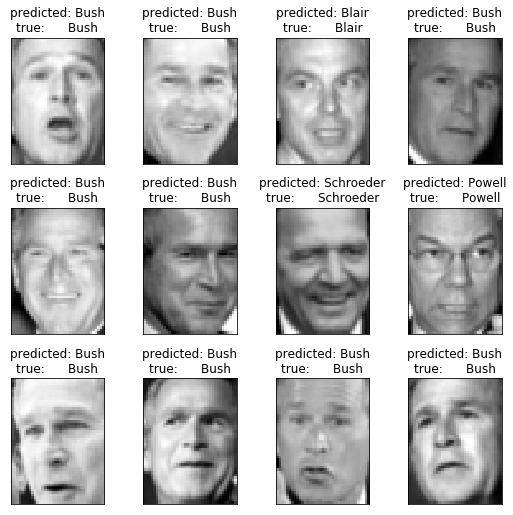

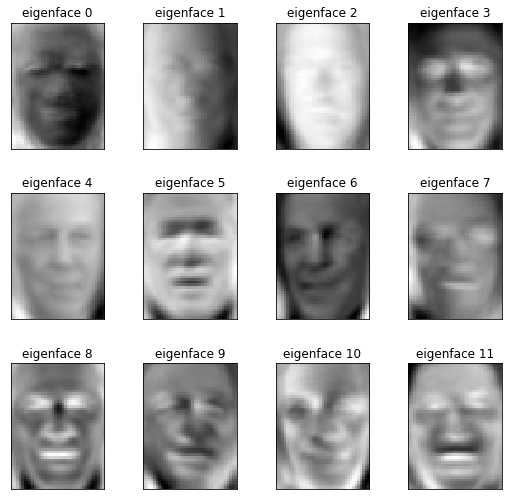

In [11]:
# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                         for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

pl.show()
